In [81]:
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import numpy as np
import xgboost as xgb

In [82]:
data = pd.read_csv('data/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding = "ISO-8859-1", delimiter=';')
data.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [83]:
data = data[['12']]
X = pd.DataFrame(data=data)

In [84]:
data

,12
0,964.4
1,1019.7
2,988.4
3,1010.8
4,1061.5
...,...
360,1002.0
361,1002.0
362,1061.5
363,1022.6


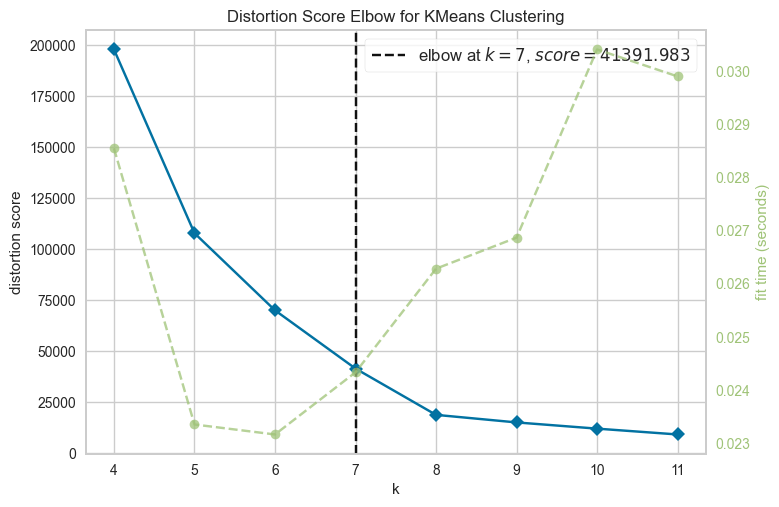

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [85]:
Elbow_M = KElbowVisualizer(KMeans(random_state=23, n_init=10), k=(4,12))
Elbow_M.fit(X)
Elbow_M.show()

In [86]:
X

,12
0,964.4
1,1019.7
2,988.4
3,1010.8
4,1061.5
...,...
360,1002.0
361,1002.0
362,1061.5
363,1022.6


In [87]:
BGM = BayesianGaussianMixture(n_components=8,covariance_type='full',random_state=1,n_init=15)
preds = BGM.fit_predict(X)
data['Cluster'] = preds


In [88]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=['12']) 
df_new[[f'predict_proba_{i}' for i in range(8)]]=pp
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))


In [89]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 6.4153e-06
[400]	valid_0's multi_logloss: 6.4153e-06
[200]	valid_0's multi_logloss: 6.30979e-06
[400]	valid_0's multi_logloss: 6.30979e-06
[200]	valid_0's multi_logloss: 6.39622e-06
[400]	valid_0's multi_logloss: 6.39622e-06
[200]	valid_0's multi_logloss: 6.22053e-06
[400]	valid_0's multi_logloss: 6.22053e-06
[200]	valid_0's multi_logloss: 6.39622e-06
[400]	valid_0's multi_logloss: 6.39622e-06
[200]	valid_0's multi_logloss: 6.39622e-06
[400]	valid_0's multi_logloss: 6.39622e-06
[200]	valid_0's multi_logloss: 6.26992e-06
[400]	valid_0's multi_logloss: 6.26992e-06
[200]	valid_0's multi_logloss: 6.84676e-06
[400]	valid_0's multi_logloss: 6.84676e-06
[200]	valid_0's multi_logloss: 6.46676e-06
[400]	valid_0's multi_logloss: 6.46676e-06
[200]	valid_0's multi_logloss: 6.46676e-06
[400]	valid_0's multi_logloss: 6.46676e-06
[200]	valid_0's multi_logloss: 6.46676e-06
[400]	valid_0's multi_logloss: 6.46676e-06


In [90]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new)
lgb_preds

array([[1.09999507e+01, 1.43315178e-05, 3.49530834e-05, ...,
        4.09226527e-17, 4.09226527e-17, 4.09226527e-17],
       [1.09999507e+01, 1.43315178e-05, 3.49530935e-05, ...,
        4.09226528e-17, 4.09226528e-17, 4.09226528e-17],
       [1.09999503e+01, 1.44522658e-05, 3.52444803e-05, ...,
        4.12629635e-17, 4.12629635e-17, 4.12629635e-17],
       ...,
       [5.86078768e-05, 1.90118317e-05, 1.09999224e+01, ...,
        5.45993780e-17, 5.45993780e-17, 5.45993780e-17],
       [1.09999507e+01, 1.43315177e-05, 3.49530887e-05, ...,
        4.09226528e-17, 4.09226528e-17, 4.09226528e-17],
       [1.09999507e+01, 1.43315177e-05, 3.49530887e-05, ...,
        4.09226528e-17, 4.09226528e-17, 4.09226528e-17]])

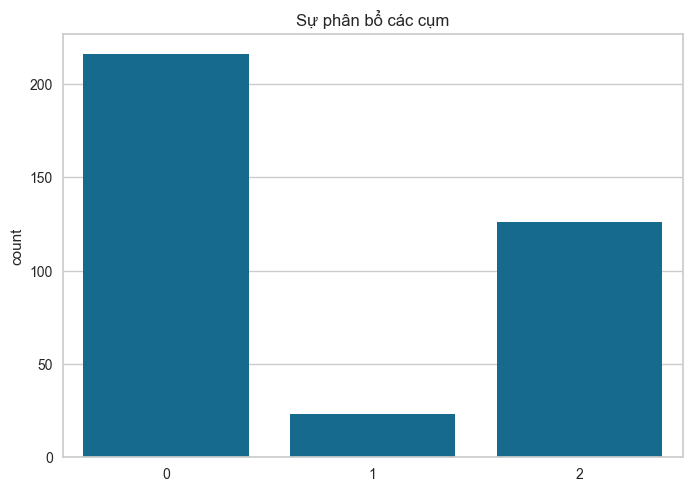

In [91]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Sự phân bổ các cụm")
plt.show()

In [92]:
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']
dtrain_clf = xgb.DMatrix(X_new.iloc[train_idx],y.iloc[train_idx], enable_categorical=True)

In [93]:
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']
params = {"objective": "multi:softprob", "tree_method": "gpu_hist", "num_class": 8}

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    dtrain_clf = xgb.DMatrix(X_new.iloc[train_idx],y.iloc[train_idx], enable_categorical=True)
    dtest_clf = xgb.DMatrix(X_new.iloc[train_idx],y.iloc[train_idx], enable_categorical=True)
    
    model = xgb.cv(
        params, dtrain_clf,
        num_boost_round=n,
        nfold=5,
        metrics=["mlogloss", "auc", "merror"],
    )
    
    model_list.append(model) 

c:\Users\chimi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [12:07:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\chimi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [12:07:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\metric\auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)
c:\Users\chimi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [12:07:13] WARNING: C:\buildkite-agent\builds\buildkite